# Exploring Clustering Results
The file containing the clustering results is stored in the processed data folder with the suffix clean. The index is set to the first __Product group key__.

As a reminder the file is organized in three columns: _Product Group Key_, _Cluster Number_ and the corresponding _Centroid_ of the cluster.

In [2]:
import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)

import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

import statsmodels.api as sm


from IPython.display import display

raw_path = os.path.join(root_dir,"data\\raw\\")
interim_path = os.path.join(root_dir,"data\\interim\\") 
processed_path = os.path.join(root_dir,"data\\processed\\")


reports_path = os.path.join(root_dir,"reports\\")
models_path = os.path.join(root_dir,"models\\")


file_name = "euc_p2_clustering_clean_mois_v2.csv"

df_prd_cluster = pd.read_csv(models_path+file_name, sep=';', encoding='utf-8').drop('Unnamed: 0',axis=1).set_index('Product')

print(df_prd_cluster.shape)
df_prd_cluster.head()


(382, 2)


,Cluster,Centroid
Product,,
GBA001BND060FS,8,"('GWF021CAE180FS',)"
GBA001BND060SS,9,"('GWM007NTA150FS',)"
GBA001BND160FS,3,"('TBG001BND180BV',)"
GBA001BND250FS,5,"('GKC005ESB100FS',)"
GBA001BNR250FS,1,"('GCO002BNR300FS',)"


## Get clients description

## Get Products description
In order to get the product features description, an inner join on the product group key is operated on the cluster result with the products description file.

Since the clustering was calculated on the second level group, some columns of the description file must be dropped in order to avoid duplicates of the first level products (mainly Promo and Standard version of the products)

In [3]:
file_name1 = "bnd_products_desc.csv"
file_name2 = "bnd_products_desc2.csv"

non_unique_features=["Key","Description","CONFEZIONE",\
                           "CONFEZIONE (Description)","IMBALLO","STD/PROMO","IMBALLO (Description)","STD/PROMO (Description)",\
                          "TIPO ARTICOLO","TIPO ARTICOLO (Description)"]

code_features = ["FAM DETTAGLIATA","FAM AGGREGATA","MARCHIO","GRUPPO MARCHIO","PACKAGING","SOTTO-TECNO",\
                           "PRODOTTO","CANALE DISTRIB","CLASSE COGE","FAM MARKETING","BIOLOGICO","GRUPPO MARCA COGE","Product Group key6"]

unbalanced = ["CANALE DISTRIB (Description)","CLASSE COGE (Description)","BIOLOGICO (Description)"]

df_produit1 = pd.read_csv(raw_path+file_name1, sep=';', encoding='iso8859_2')\
                    .drop(non_unique_features,axis=1)\
                    .drop(code_features,axis=1)\
                    .drop_duplicates()\
                    .dropna().reset_index(drop=True).apply(lambda x:x.astype(str).str.upper())
                    
                
df_produit2 = pd.read_csv(raw_path+file_name2, sep=';', encoding='iso8859_2')\
                    .drop(non_unique_features,axis=1)\
                    .drop(code_features,axis=1)\
                    .drop_duplicates()\
                    .dropna().reset_index(drop=True).apply(lambda x:x.astype(str).str.upper())
                

m = pd.merge(df_produit1.iloc[:,:1],df_produit2.iloc[:,:1],how='outer',on=['Product Group key'],indicator='both').drop_duplicates()              
dif = m[m['both']!='both'].reset_index(drop=True)

# df_produit = pd.concat([df_produit1,df_produit2], axis=0, ignore_index=True, copy=True)\
#                 .drop_duplicates(["Product Group key","Product Group key2"])


#df_produit1.to_csv(interim_path+"\\unique\\bnd_products_desc1.csv",sep=';',encoding='iso8859_2',index=False)
#df_produit2.to_csv(interim_path+"\\unique\\bnd_products_desc2.csv",sep=';',encoding='iso8859_2',index=False)
#df_produit.to_csv(interim_path+"\\unique\\bnd_products_desc.csv",sep=';',encoding='iso8859_2',index=False)


df_produit = df_produit2.drop_duplicates(["Product Group key"])
#Remove XX products weird
mask_XX = df_produit["Product Group key3"].str.endswith("XXX")
df_produit = df_produit[~mask_XX]



#Join with clusters
product_cluster = df_produit.join(df_prd_cluster,on='Product Group key',how='inner').reset_index(drop = True)
print(product_cluster.shape)
product_cluster.head()
#product_cluster.to_csv(interim_path+"\\unique\\bnd_product_cluster.csv",sep=';',encoding='iso8859_2',index=False)

(382, 19)


,Product Group key,Product Group key2,Product Group key3,Product Group key4,Product Group key5,FAM DETTAGLIATA (Description),FAM AGGREGATA (Description),MARCHIO (Description),GRUPPO MARCHIO (Description),PACKAGING (Description),SOTTO-TECNO (Description),PRODOTTO (Description),CANALE DISTRIB (Description),CLASSE COGE (Description),FAM MARKETING (Description),BIOLOGICO (Description),GRUPPO MARCA COGE (Description),Cluster,Centroid
0,GLA006BND100FS,FRABNDASTELA,FRABNDASTE,FRABND,FRA01,LAITUE,ASTERIX,BONDUELLE,BONDUELLE,0100 N/A,SALADES,MINI LAITUE VERTE,ARTICLES GP,PFC+ FRAIS,M'AMA NON M'AMA,NO,BND,5,"('GKC005ESB100FS',)"
1,GBA001BND060FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0060 N/A,SALADES,MACHE,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,NO,BND,8,"('GWF021CAE180FS',)"
2,GBA001BND060SS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0060 N/A,SALADES,MACHE,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,NO,BND,9,"('GWM007NTA150FS',)"
3,GBA001BND160FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0160 N/A,SALADES,MACHE,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,NO,BND,3,"('TBG001BND180BV',)"
4,GBA001BND250FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0250 N/A,SALADES,MACHE,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,NO,BND,5,"('GKC005ESB100FS',)"


In [18]:
display(df[["Product Group key2"]].drop_duplicates())
display(df[["Product Group key3"]].drop_duplicates())
display(df[["Product Group key4"]].drop_duplicates())



,Product Group key2
0,FRABNDASTELA
1,FRABNDBOUQBA
6,FRABNDBURGBG
10,FRABNDCAROCH
12,FRABNDEPINEP
15,FRABNDJPOUCO
21,FRABNDLAITLA
22,FRABNDLAITLI
24,FRABNDLAITLV
29,FRABNDMESAWA


,Product Group key3
0,FRABNDASTE
1,FRABNDBOUQ
6,FRABNDBURG
10,FRABNDCARO
12,FRABNDEPIN
15,FRABNDJPOU
21,FRABNDLAIT
29,FRABNDMESA
75,FRABNDSLFR
86,FRABNDSOUP


,Product Group key4
0,FRABND
99,FRABNR
125,FRABNG
129,FRABRN
137,FRACAE
142,FRACAR
155,FRACQT
178,FRADCO
189,FRADLZ
197,FRAESB


## Merge Products and Clients tables

In [167]:
# produit_client_cluster = pd.merge(product_cluster,client_df,how='inner', left_on=["Client"],right_on =["Key_lvl4"] )#.drop(["Key_lvl4"],axis=1)



# clusters = produit_client_cluster["Cluster"]
# centroids = produit_client_cluster["Centroid"]
# produit_client_cluster = produit_client_cluster.drop(["Cluster","Centroid"],axis=1)

# pos = len(produit_client_cluster.columns)
# produit_client_cluster.insert(pos,"Cluster",clusters)
# produit_client_cluster.insert(pos+1,"Centroid",centroids)


# all_features = produit_client_cluster.columns[:-2].drop(unbalanced)



# print(produit_client_cluster.shape)
# produit_client_cluster.tail()


# absent = produit_client_cluster[produit_client_cluster["Key_lvl5"].isnull()]["Client"].drop_duplicates()
# absent.tail()




all_features = product_cluster.columns[:-2]


Save the final result into a csv file for further exploration

In [323]:
filename = 'bnd_product_cluster_clean.csv'
file_name = "p2_clustering_clean_mois.csv"
product_cluster.to_csv(processed_path+filename,sep=';',encoding='iso8859_2')


# Homogeneity Test
In order to detect specific caraterstics for each resulted cluster we perform a statistic test based on Pearsons chi-square score with the hypothesis of a uniform distribution.

Features with the pvalues lower than 0.1 are displayed for analysis

In [325]:
def cramer_v(chisq,n,k,r=1):
    return math.sqrt(chisq/(n * min(k-1,r-1) ))

## Calculate modalities frequency through clusters
As a first step, all the distrubtions of modalities across features and clusters are calculated and stored in one array structered as follows:

One array for each cluster which contains a dictionnary of features. Each feature is again a dictionary of modalities and their occurence in that cluster

In [326]:
#get the features
features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#array to store each cluster and freq for all the features
clusters_feature_dist = [0] #to shift the indices to clusters

#loop trhough features

for c in clusters:
    feature_dist = dict()
    for feature in features:
        freq = product_cluster[product_cluster['Cluster']==c].groupby(feature)[feature].count()
        feature_dist[feature]=freq.to_dict()
    clusters_feature_dist.append(feature_dist)



## Chi-square test over clusters

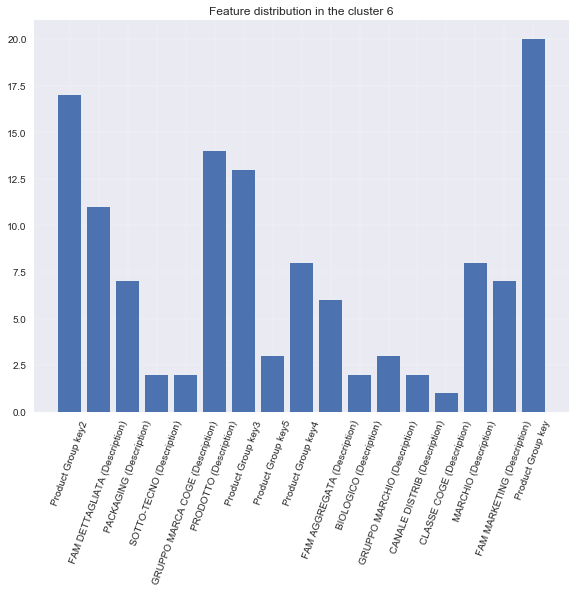

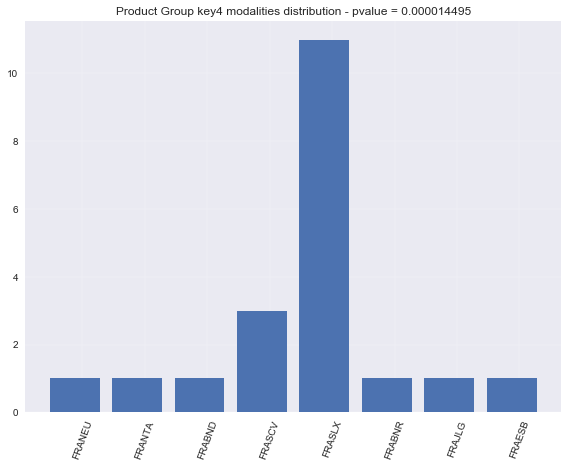

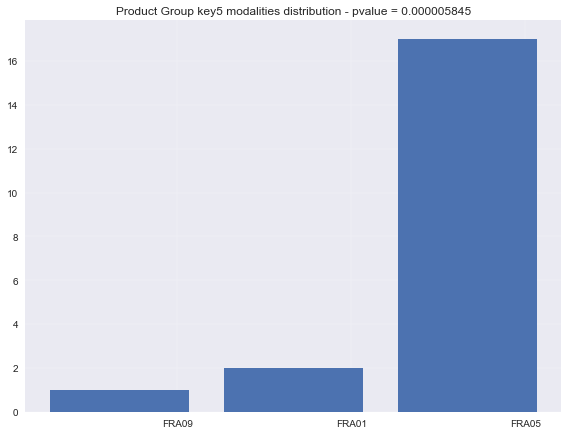

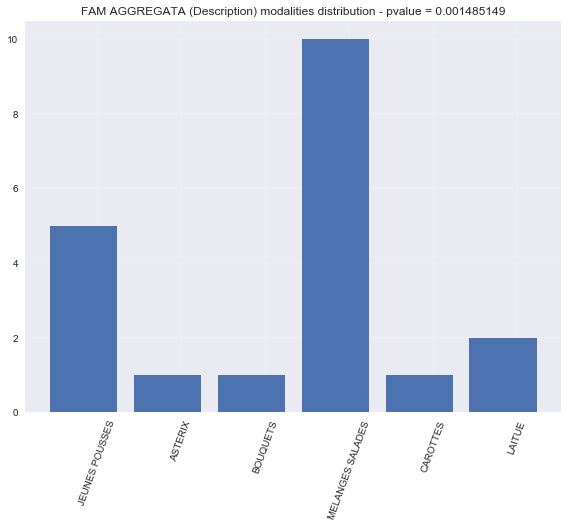

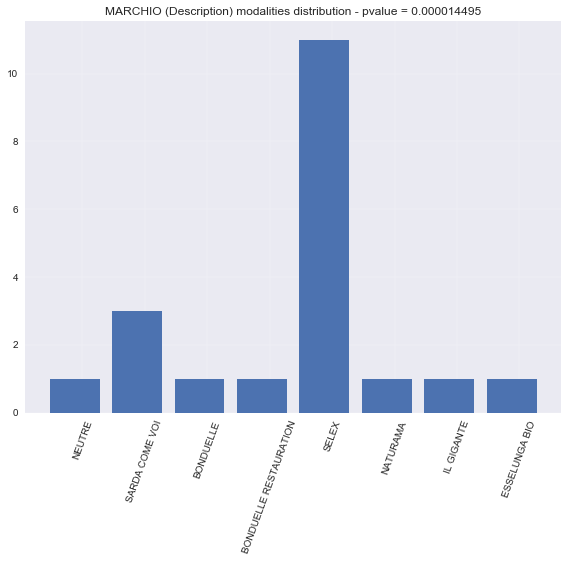

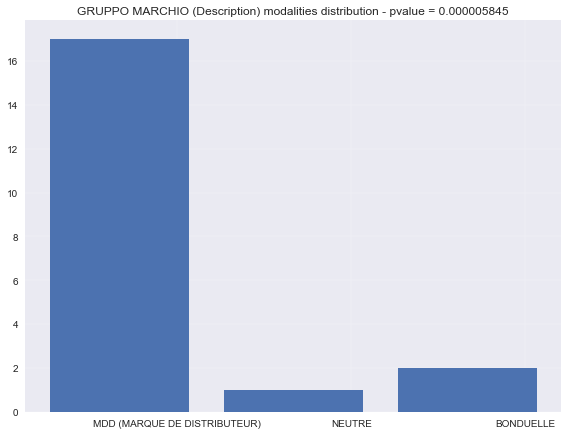

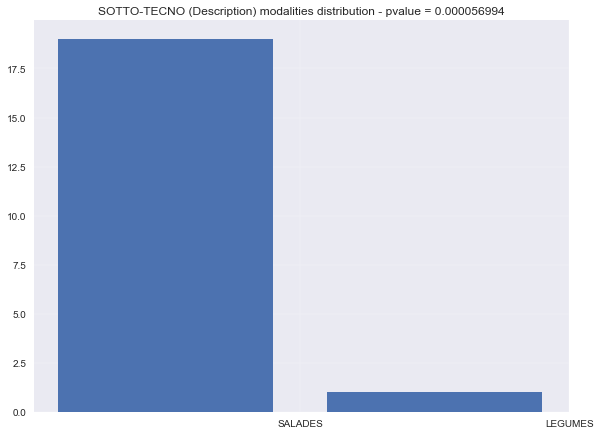

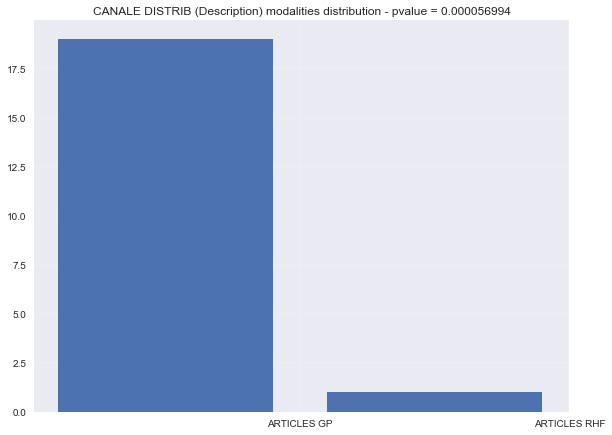

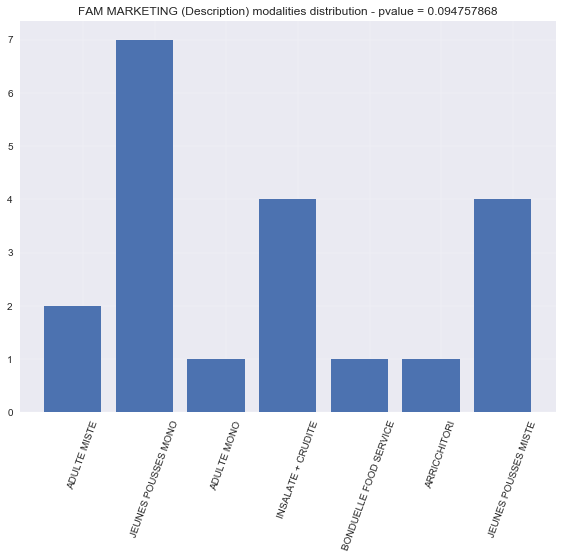

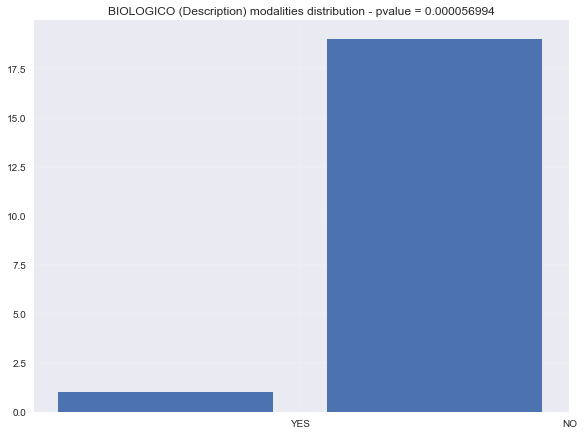

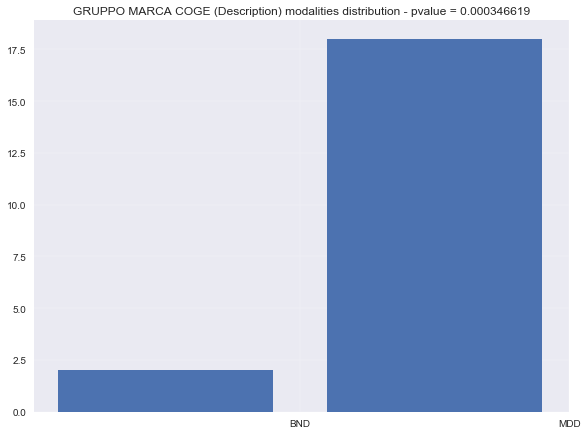

In [485]:
from scipy.stats import chisquare

pthreashold = 0.2

#get the features
features = all_features

clusters = [6]


res_features_over_cluster = [0]
for c in clusters:
    #align each feature with its distrubtion in this cluster c
    cluster_feature_dist = clusters_feature_dist[c]
    dist = [len(x) for x in list(cluster_feature_dist.values())]
    keys = list(cluster_feature_dist.keys())    

    #plot the dist of number of elements by feature in this clust
    plt.title("Feature distribution in the cluster %d"%c)
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    
    #for each feature display its distribution over modalities
    for feature in features:
        #get information from the previous array
        cluster_feature_dist = clusters_feature_dist[c]
        feature_distribution = list(cluster_feature_dist[feature].values())
        feature_keys = list(cluster_feature_dist[feature].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s modalities distribution - pvalue = %.9f"%(feature,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
    plt.show(block = True)
    


## Calculate modalities frequency through features

In [328]:
#get the features
features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#dict to store each feater and freq for all the clusters
features_clust_dist = dict()

#invert the dict and get it by feature 
for f in features:
    freq = dict()
    for c in clusters: 
        freq[c] =  clusters_feature_dist[c][f]
    features_clust_dist[f] = freq

## Chi-square test over features

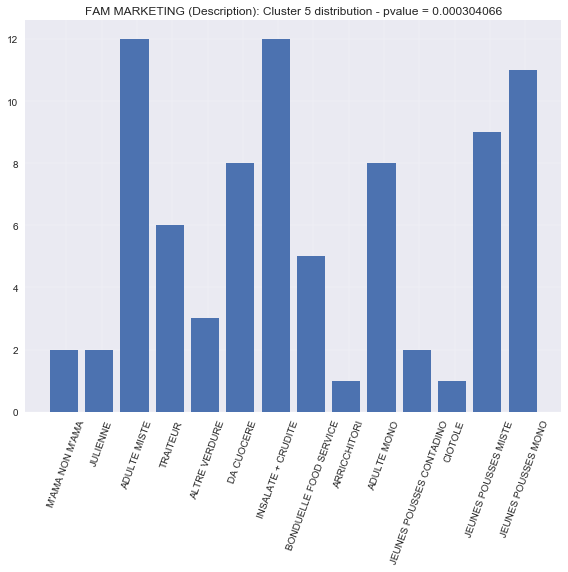

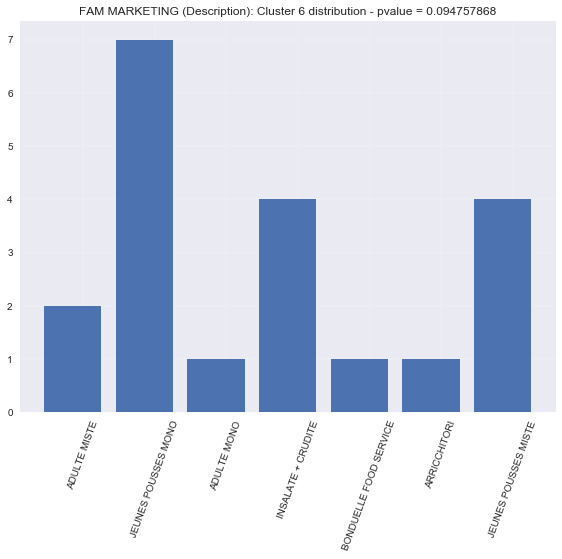

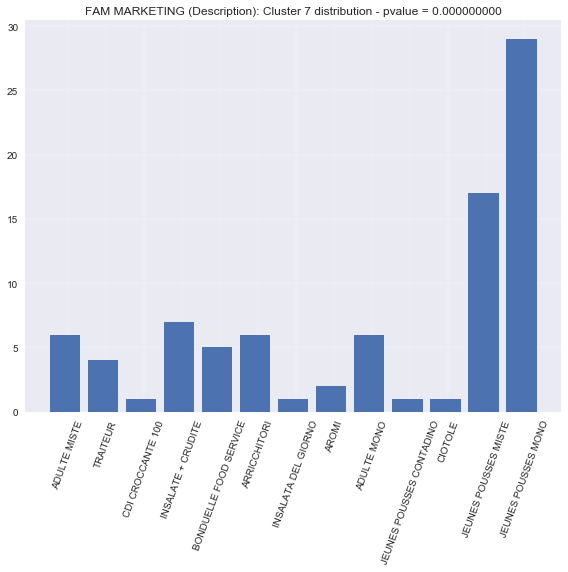

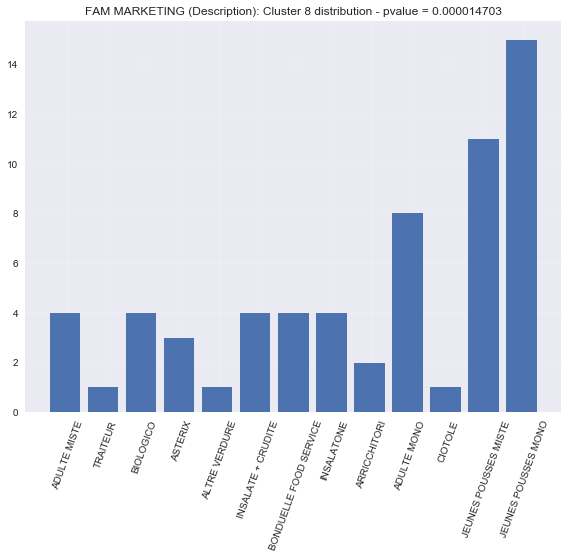

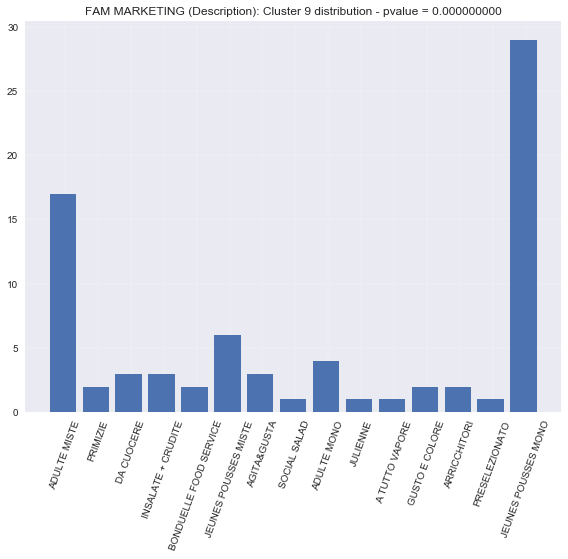

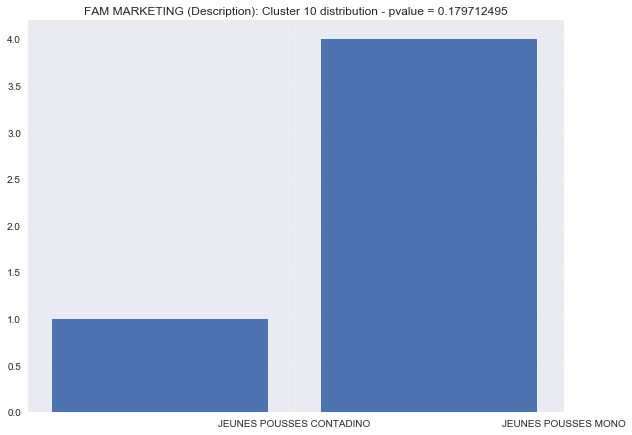

In [329]:
pthreashold = 0.2
clusters = set(product_cluster['Cluster'].values)

features = all_features
features = ["FAM MARKETING (Description)"]

for f in features:
    for c in clusters:
        #get information from the previous array
        feature_clust_dist = features_clust_dist[f]
        feature_distribution = list(feature_clust_dist[c].values())
        feature_keys = list(feature_clust_dist[c].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s: Cluster %d distribution - pvalue = %.9f"%(f,c,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
            
    plt.show(block = True)     



## Modalities distribution

In [330]:
clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)
#get the features
features = product_cluster.columns[0:-2]
features = features.drop(unbalanced)


modalities_clust_dist = dict()

for f in features:
    feature_sum=[]
    modalities = set(product_cluster[f].values)
    modalities_distribution=dict()
    for m in modalities:
        modality_distribution = np.zeros((nclusters+1))
        for c in clusters:
            #get information from the previous array
            feature_clust_dist = features_clust_dist[f]
            modality_distribution[c] +=(feature_clust_dist[c][m] if m in feature_clust_dist[c] else 0)
        modalities_distribution[m] = modality_distribution    
    modalities_clust_dist[f] = modalities_distribution 

## Chi-square test for modalities over clusters

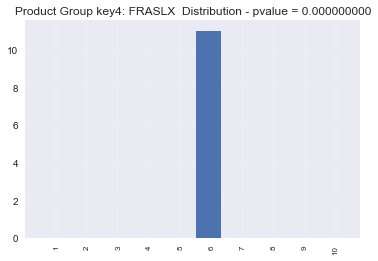

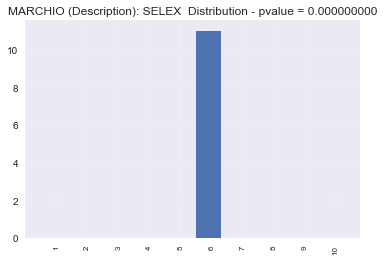

In [331]:
%matplotlib inline

clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)


pthreashold = 0.2

n_min_dist = 1
min_members = 5


min_dust  = True
for f in features:
    modalities = set(product_cluster[f].values)
    r = len(modalities)
    for m in modalities:
        modality_dist = modalities_clust_dist[f][m]
        md = np.count_nonzero(modality_dist)<=n_min_dist and np.max(modality_dist)>min_members
        chisq, p = chisquare(modality_dist)
        if p<pthreashold and (md and min_dust):
            plt.figure()
            plt.title("%s: %s  Distribution - pvalue = %.9f"%(f,m,p))
            plt.bar(np.arange(nclusters)+1,modality_dist[1:])
            plt.xticks(np.arange(nclusters)+(1.0/nclusters)+1,np.arange(nclusters)+1,rotation=90,size=8)
            if np.max(modality_dist[1:])<10: plt.ylim(0,10)
    plt.show(block = True)  

## MCA Analysis

### Remove unbalanced columns

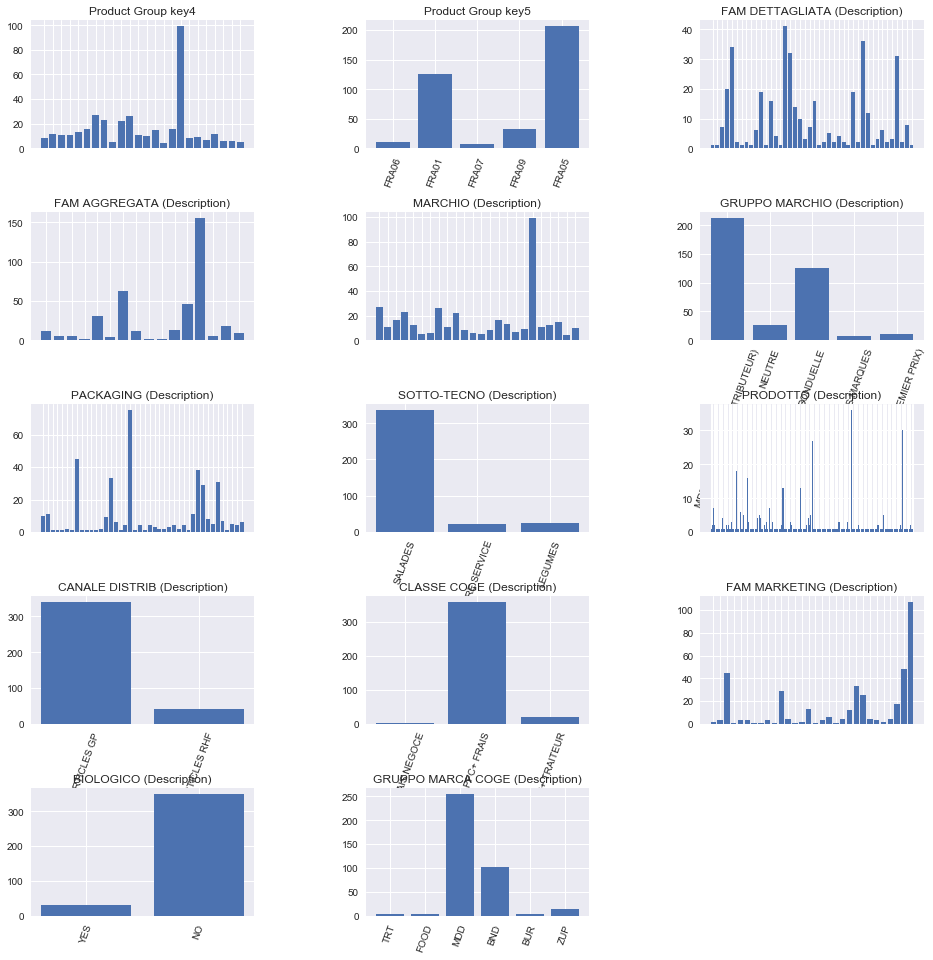

In [17]:
features_df = product_cluster.iloc[:,3:-2]
plt.figure(figsize=(16,20))
features = features_df.columns
for i,f in enumerate(features):
    counts = features_df.groupby([f])[f].count().to_dict()
    dist = list(counts.values())
    keys = list(counts.keys())
    chisq, p = chisquare(dist)
    plt.subplot(6,3,i+1)
    plt.title("%s"%(f))
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    if len(keys)>10: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)      
plt.show()

### Apply MCA on Products

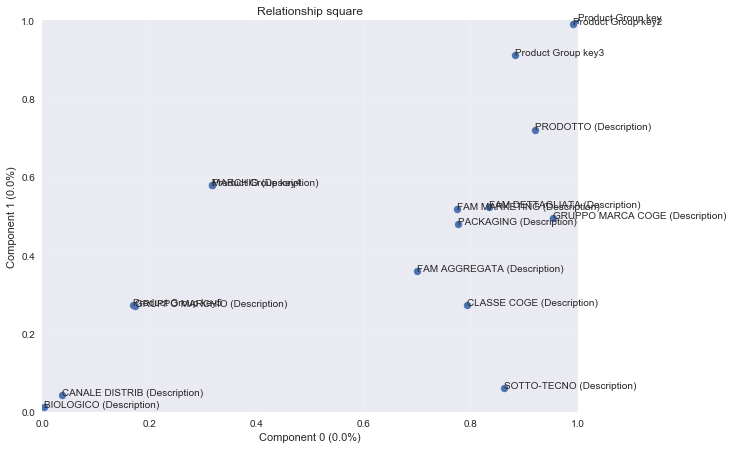

In [332]:
import prince

unbalanced = ["CANALE DISTRIB (Description)","CLASSE COGE (Description)","BIOLOGICO (Description)"]


features_df = product_cluster.iloc[:,1:-2].drop(unbalanced,axis=1)
features_df = df_produit
mca = prince.MCA(features_df)
mca.plot_relationship_square()
plt.show()

### Apply MCA on Clients

In [ ]:
import prince
features_df = client_df.astype(str).fillna("NA")
mca = prince.MCA(features_df)
mca.plot_relationship_square()
plt.show()

## Classification Tree

In [492]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier  
import subprocess
from sklearn.tree import  export_graphviz
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=class_names )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

        
drop = ["Product Group key","Centroid","PRODOTTO (Description)","PACKAGING (Description)"]
keep = ["FAM DETTAGLIATA (Description)","FAM AGGREGATA (Description)","MARCHIO (Description)","GRUPPO MARCHIO (Description)","SOTTO-TECNO (Description)","CANALE DISTRIB (Description)","CLASSE COGE (Description)","FAM MARKETING (Description)","Cluster"]
        
#data = product_cluster.drop(drop,axis=1)
data = product_cluster[keep]


# cat_data = []
# i=0
# for label,col in data.iteritems():
#     cat_data.append(col.astype('category'))
    
# df = pd.DataFrame(np.array(cat_data).T,columns = data.columns)

lb = LabelBinarizer()

X = pd.get_dummies(data.drop(["Cluster"],axis=1).iloc[:,:])
print(X.shape)
display(data.head())
features = X.columns
y = lb.fit_transform(data.values[:,-1].astype(int).T)
y = data.values[:,-1].astype(int)

(382, 125)


,FAM DETTAGLIATA (Description),FAM AGGREGATA (Description),MARCHIO (Description),GRUPPO MARCHIO (Description),SOTTO-TECNO (Description),CANALE DISTRIB (Description),CLASSE COGE (Description),FAM MARKETING (Description),Cluster
0,LAITUE,ASTERIX,BONDUELLE,BONDUELLE,SALADES,ARTICLES GP,PFC+ FRAIS,M'AMA NON M'AMA,5
1,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,SALADES,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,8
2,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,SALADES,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,9
3,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,SALADES,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,3
4,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,SALADES,ARTICLES GP,PFC+ FRAIS,JEUNES POUSSES MONO,5


In [493]:
x_data  = data.drop(["Cluster"],axis=1).iloc[:,:]
y_data = data.values[:,-1].astype(int)


from sklearn.feature_extraction import DictVectorizer

X_dict = x_data.T.to_dict().values()


vect = DictVectorizer(sparse=False)
X_vector = vect.fit_transform(X_dict)
print(X_vector.shape)
y = lb.fit_transform(y_data.T)
y = y_data.T
X = X_vector

(382, 125)


In [498]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  

classifier = DecisionTreeClassifier(criterion = "gini", max_depth=None, min_samples_leaf=1)  
classifier.fit(X_train, y_train)


# from sklearn.svm import SVC
# classifier = SVC()
# classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)

## Evaluation the algorithm

In [495]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_recall_fscore_support as report
#print(confusion_matrix(y_test, y_pred)) 
precision,recall,fscore,support = report(y_test, y_pred,warn_for=())
print(precision.mean(),recall.mean(),fscore.mean(),support.sum())
 #print(classification_report(y_test, y_pred))

# imp = np.array(classifier.feature_importances_)
# imp_ft = features[np.argsort(imp)[::-1]]
# print(imp_ft.values)

0.163285836074 0.153725490196 0.148187373144 77


In [499]:
visualize_tree(classifier, features,class_names=True)

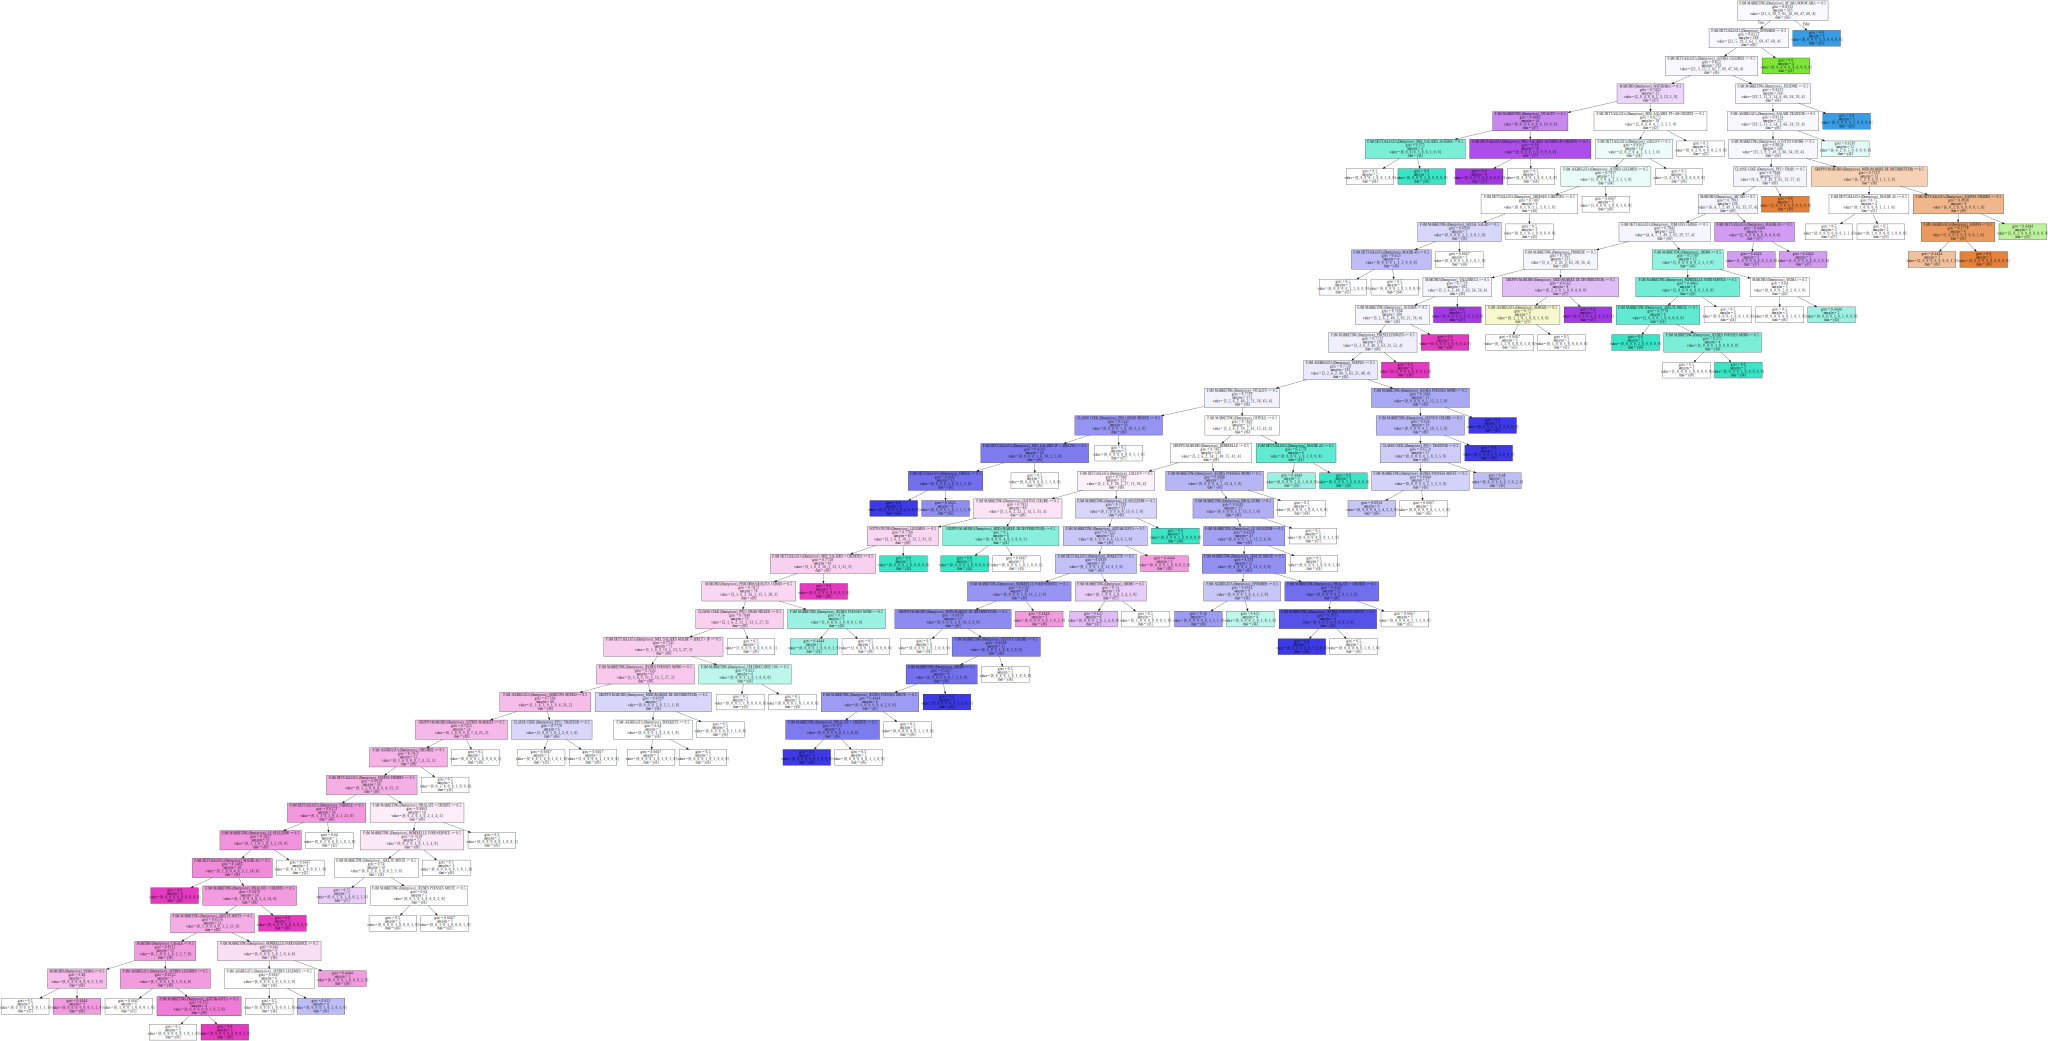

In [497]:
from graphviz import Graph,Source
from IPython.display import SVG

graph = Source(export_graphviz(classifier, out_file=None
   , feature_names=features, class_names=True
   , filled = True))

display(SVG(graph.pipe(format='svg')))

In [507]:
print(classifier.tree_)